# Algorithm / Analysis for Analyzing The Impact of Ridesharing
### plewknew

The purpose of this analysis is to provide a way of looking back on taxi ride data to understand the impact of aggregated ridesharing. The goal is to understand the potential impact on NYC traffic congestion and passenger savings if every ride in NYC was aggregated with other close rides. A way of thinking about ride aggregation is similar to Uber Pool, wherein users of the app will join other, random, users of the app to take a ride together. 

Of course, there have been limits of reasonability that have been enforced to aggregate rides together. These include:
- Rides can only be aggregated if within 20 mins of another ride
- Rides can only be aggregated if within a certain distance of another ride
- Only rides up to 4 passengers can be aggregated together.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from shapely.geometry import Point, Polygon, shape
import geopandas as gpd
import descartes
import shapefile as shp


## Importing and Visualizing the Data

Note the data can be downloaded from: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [ ]:
df_june_data = pd.read_csv('yellow_tripdata_2016-06.csv')

Let's see what the data looks like at a high level.

In [9]:
df_june_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1,N,-73.977463,40.753979,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0.0,0.3,28.30
4,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.5,0.5,0.5,2.96,0.0,0.3,17.76


In [10]:
df_june_data.shape

(11135470, 19)

In [11]:
df_june_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

Visualizing the data will also be valuable.

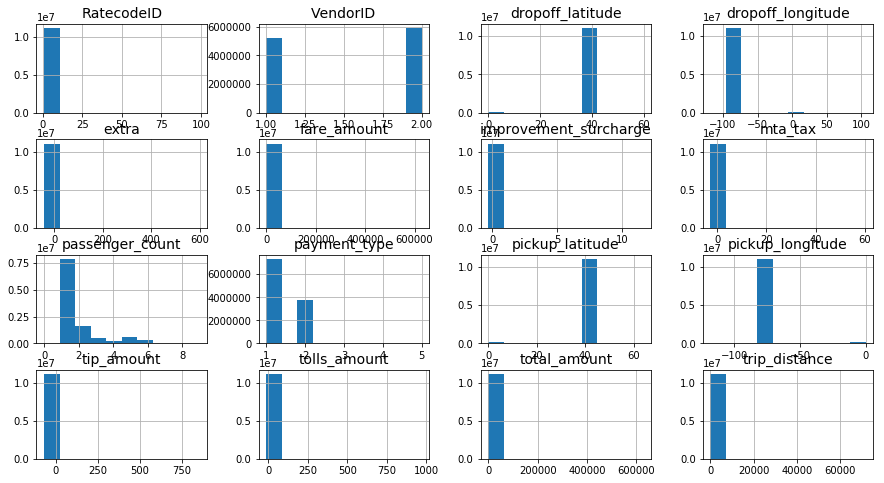

In [12]:
ax = df_june_data.hist(figsize = (15,8))

for i in range(4):
    for x in ax[i]:
        x.title.set_size(14)
        x.xaxis.label.set_size(4)


First things first, I should probably do some data prep / preprocessing. We can see from the histograms above, some of the data is wrong. In particular, we can explicitly find incorrect data in the latitude and longitude, because we know what the long/lat of NYC is. Lets start off by getting rid of the incorrect values from this then see what the histograms look like. We can additionally see below that there are some values that are obviously incorrect. 

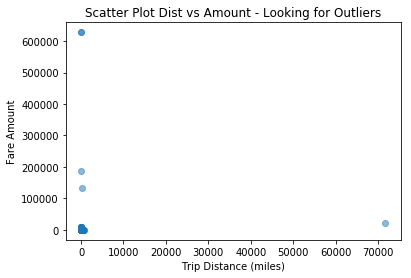

In [ ]:
plt.scatter(df_june_data['trip_distance'], df_june_data['fare_amount'], alpha=0.5)
plt.title('Scatter Plot Dist vs Amount - Looking for Outliers')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount')
plt.show()

We want to remove some of the outliers/mistakes of the data, as generally restrict the data to that we are able to performa analysis. Note that there is so much data that I don't mind taking out some values.

In [ ]:
#Removing data
NYC_Long_max = -73.620402
NYC_Long_min = -74.269642
NYC_Lat_max = 41.117448
NYC_Lat_min = 40.496821

removed_data = df_june_data[((df_june_data['trip_distance'] < 10) & (df_june_data['fare_amount'] > 200))]

df_june_data_processed = df_june_data[(df_june_data['dropoff_longitude'] < NYC_Long_max) & (df_june_data['dropoff_longitude']>NYC_Long_min) 
                                      & (df_june_data['dropoff_latitude'] < NYC_Lat_max) & (df_june_data['dropoff_latitude']>NYC_Lat_min)
                                      & (df_june_data['pickup_longitude'] < NYC_Long_max) & (df_june_data['pickup_longitude']>NYC_Long_min) 
                                      & (df_june_data['pickup_latitude'] < NYC_Lat_max) & (df_june_data['pickup_latitude']>NYC_Lat_min)
                                      & (df_june_data['total_amount'] < 100000) & (df_june_data['trip_distance']<80)
                                      & (df_june_data['fare_amount'] < 500) & (df_june_data['fare_amount'] > 0)
                                      & (df_june_data['tpep_pickup_datetime'].apply(lambda x: isinstance(x,str)) == True)
                                      & (df_june_data['tpep_dropoff_datetime'].apply(lambda x: isinstance(x,str))==True)]


df_june_data_processed = df_june_data_processed[~df_june_data_processed.isin(removed_data)]



Great. Now let's look at the updated histograms to see if they have been improved in any way.

I also decided to look at a few more charts for interests sake.

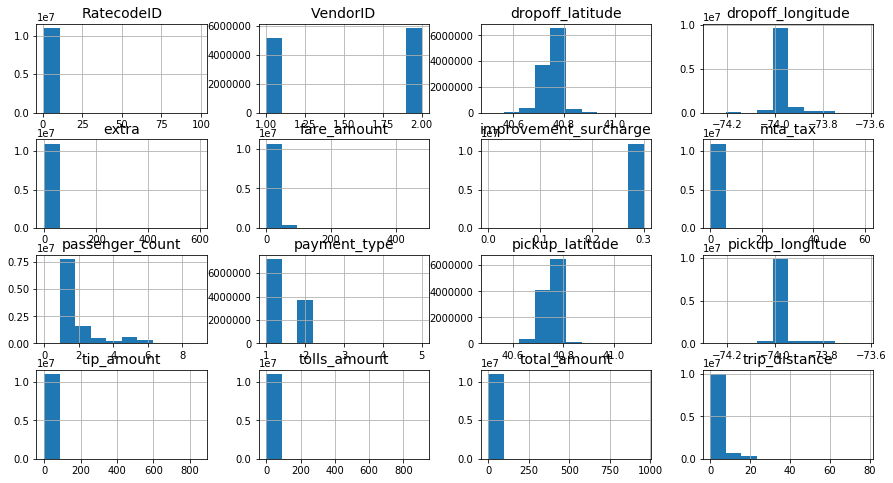

In [ ]:
ax = df_june_data_processed.hist(figsize = (15,8))

for i in range(4):
    for x in ax[i]:
        x.title.set_size(14)
        x.xaxis.label.set_size(4)

Now that those look fairly good, lets take a look at some other exploratory charts that may be interesting (note that I only included the ones that I was interested in...where there were many that I looked at and did not include in this final pass). 

Also note the structure of the data. We can see there is a 'fixed rate' amount from the horizontal line across the chart at around 50$. We also see that that there generally seems to be a minimum linear relationship between distance and fare amount, with some additional charges above this. I am thinking that The minimum linear relationship can be thought of when there is very little traffic, and anything above that additional cost of waiting in traffic can be factored in.

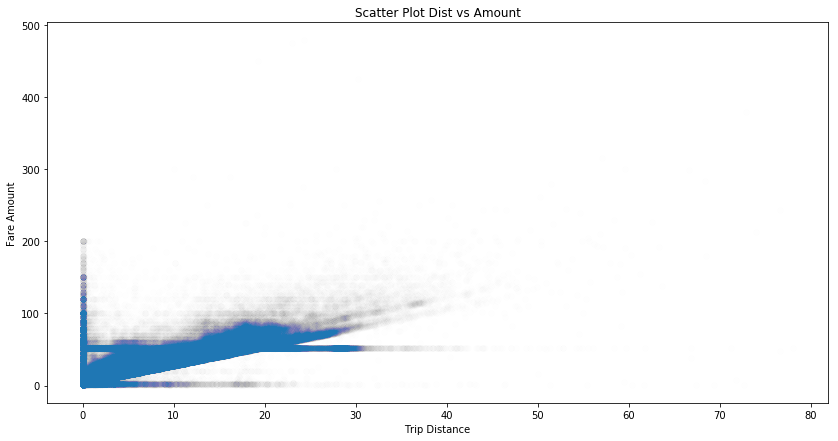

In [ ]:
plt.figure(figsize=(14, 7))
plt.scatter(df_june_data_processed['trip_distance'], df_june_data_processed['fare_amount'], alpha=0.005)
plt.title('Scatter Plot Dist vs Amount')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

Can we see the geographical structure of NYC by simply plotting the latitude and longditude? YES! Look below. You are even able to pick out potential landmarks from further into the bronx or white plains (clusters of points where people will request to be dropped off).

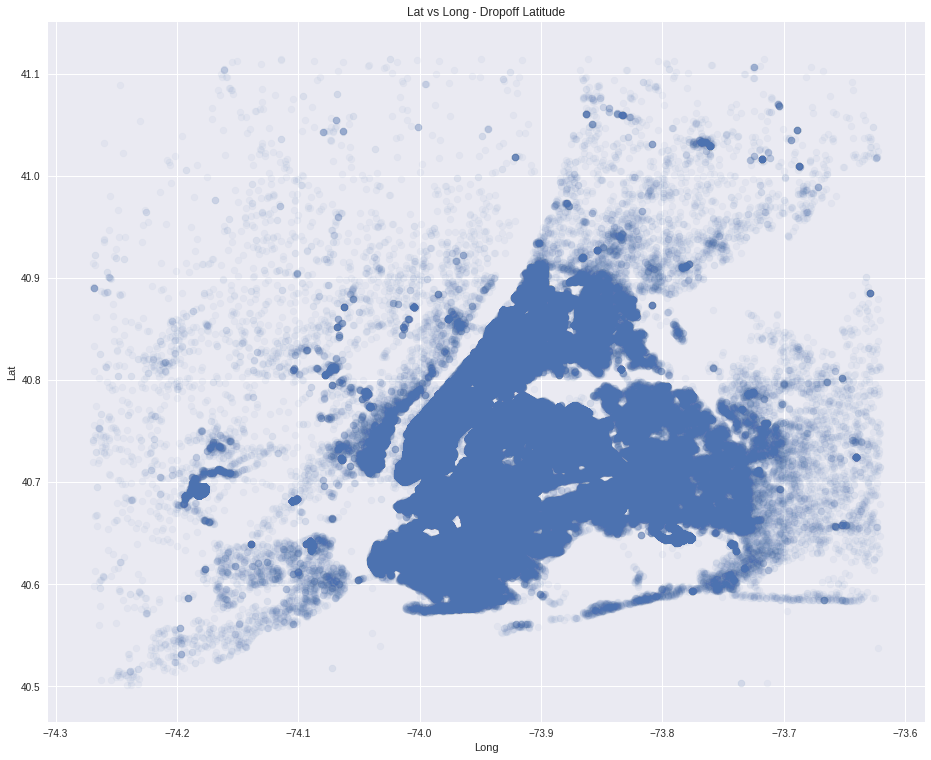

In [129]:
plt.figure(figsize=(14, 12))
plt.scatter(df_june_data_processed['dropoff_longitude'], df_june_data_processed['dropoff_latitude'], alpha=0.05)
plt.title('Lat vs Long - Dropoff Latitude')
plt.xlabel('Long')
plt.ylabel('Lat')
plt.show()

## Metrics
Several Ideas for metrics to see what the impact of having several rides joined into one:

- Amount of car-miles reduced (this is a measure of congestion)
- Amount of emissions reduced on average
- Cost savings per passenger

We will see these become useful as we start to apply the algorithm

First thing that we do is look at processing the data further to create a few new useful features. In addition we want to convert all of our features to the appropriate data types.

In [ ]:
# This function is to round down times in order to sort them in the next step
def timerounddown10(dt):
    a, b = divmod(dt.minute, 10)
    try:
      return datetime.datetime(dt.year, dt.month, dt.day, dt.hour, int(10*a), 0)
    except:
      return np.nan

In [ ]:
#General data processing is below.
df_june_data_processed['Index']=df_june_data_processed.index
df_june_data_processed['tpep_pickup_datetime'] = pd.to_datetime(df_june_data_processed['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df_june_data_processed['tpep_dropoff_datetime'] = pd.to_datetime(df_june_data_processed['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
df_june_data_processed['tpep_pickup_datetime'] = df_june_data_processed.tpep_pickup_datetime.dt.to_pydatetime()
df_june_data_processed['tpep_dropoff_datetime'] = df_june_data_processed.tpep_dropoff_datetime.dt.to_pydatetime()
#We want to create this variable because we will use it explicitly in the algorithm
df_june_data_processed['tpep_pickup_datetime_10min_rounddown'] = df_june_data_processed['tpep_pickup_datetime'].apply(lambda x: timerounddown10(x))
df_june_data_processed.dropna(subset=['tpep_pickup_datetime_10min_rounddown'])
df_june_data_processed['passenger_count'] = df_june_data_processed['passenger_count'].replace(0,1)



### Subsetting to First Week June

Because of the massive size of the dataset, we want to restrict it to only the first two weeks of June.

In [ ]:
df_june_data_processed_subset = df_june_data_processed[(df_june_data_processed['tpep_pickup_datetime']>'2016-06-01 00:00:00')
                                                      &(df_june_data_processed['tpep_pickup_datetime']<'2016-06-14 23:59:59')]


In [18]:
df_june_data_processed_subset.shape

(2260483, 21)

As you can see from above, we have greatly reduced the number of rows.


## Applying the Algorithm

Below we define all of the functions that we will need in order to get the clusters as well as get the data on how we have improved the metrics that we mention above. The main function for the algorithm is 'hierarchical_with_constraints'. It is named this way because the original idea for this came from a modified version of hierarchical clustering.


### Algorithm Basics (see report for more details):

- Sort 2 lists by 10 min increments and by Lat AND Long
- Greedily search through sorted lists, looking for rides that will 'complete' a set
- Only look through 10 min segments WITHIN and AFTER the segment is in
- Once a set is completed, look to remove into its own set
- Do this in place


NOTE:

I assumed that ride coming from the same location could be clustered. Note that I was more picky to select rides that were very close on pickup, but less close on dropoff.

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
!mkdir borough_bounds

In [ ]:
!bash -c 'mv geo_export_bc671649-64a6-43e2-8565-6e2fc912466e.dbf /content/borough_bounds'
!bash -c 'mv geo_export_bc671649-64a6-43e2-8565-6e2fc912466e.prj /content/borough_bounds'
!bash -c 'mv geo_export_bc671649-64a6-43e2-8565-6e2fc912466e.shp /content/borough_bounds'
!bash -c 'mv geo_export_bc671649-64a6-43e2-8565-6e2fc912466e.shx /content/borough_bounds'


In [ ]:
import time

'''First we have a function for sorting our data in the way that we previously indicated.'''
def sort_for_clustering(data):
    data_sorted = data.sort_values(by=['tpep_pickup_datetime_10min_rounddown','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'])
    return data_sorted


'''Next we have the actual algorithm that will run through different potential combinations of rides to combine, and will
pick routes that we are able to combine according to our constraints outlined earlier. Also note that we are combining
the data that we are interested in (the amount of driver miles / money saved)'''

def hierarchical_with_constraints(data, input_shapefile):
    pbar = tqdm(total=len(data))

    #Note that an input to this function should be a list of dictionaries
    
    data_compare=[]
    saved_info=[]
        
    while len(data)>1:
        
        #we set the 'ride' variable to the first row in data, then remove the row
        ride = data[0]
        data.pop(0)
        pbar.update(1)
      
          #we get some data from our selected first row
        num_riders = ride['passenger_count']
        saved_info_object={}
        saved_info_object={'pickup_latitude':ride['pickup_latitude'],'pickup_longitude':ride['pickup_longitude'],'borough':'','time':ride['tpep_pickup_datetime'],'distance':0,'money':0,'people':num_riders}
      
      
      
        set_object = []
        set_object.append(ride['Index'])
      
        i=0
      
      
      #We want trips only within the next 20 mins
      while num_riders<4 and (data[i]['tpep_pickup_datetime_10min_rounddown'] == ride['tpep_pickup_datetime_10min_rounddown'] or data[i]['tpep_pickup_datetime_10min_rounddown'] == ride['tpep_pickup_datetime_10min_rounddown'] + datetime.timedelta(minutes=10)):
          
          #We want rides only within a certain bound for latitude and longitude
        if (
            abs(data[i]['pickup_longitude']-ride['pickup_longitude']) <0.01 and
            abs(data[i]['pickup_latitude']-ride['pickup_latitude']) <0.01 and
            abs(data[i]['dropoff_longitude'] -ride['dropoff_longitude']) <0.05 and
            abs(data[i]['dropoff_latitude'] -ride['dropoff_latitude']) <0.05):
            
            #Finally, we want to only take up to 4 passengers
            if num_riders+data[i]['passenger_count']<=4:
                num_riders = num_riders + data[i]['passenger_count']
                set_object.append(data[i]['Index'])
              
                saved_info_object['distance'] = saved_info_object['distance']+ data[i]['trip_distance']
                saved_info_object['money'] = saved_info_object['money']+ data[i]['fare_amount']
                saved_info_object['people'] = num_riders

              
              
                #if we have found a ride to pool with, we take the pool out of the list
                data.pop(i)
                i=i-1
                pbar.update(1)

            i = i + 1
          
            #If we have reached the end and found no trips to pool with, let's break
            if i >= len(data)-1:
                break
            
        #Add the set of rides to pool together.
        data_compare.append(set_object)
        saved_info.append(saved_info_object)  
      
    return data_compare, saved_info
                


In [ ]:
#The first part of the algorithm is to sort all of the records according to time and position
df_june_data_processed_subset_sorted = sort_for_clustering(df_june_data_processed_subset)

In [33]:
#We then have to actually sort through and cluster rides together
start = time.time()
temp_df = df_june_data_processed_subset_sorted.copy()
clustered_set, saved_results = hierarchical_with_constraints(temp_df.to_dict('records'),'/content/borough_bounds/geo_export_bc671649-64a6-43e2-8565-6e2fc912466e.shp')
print('Time to run: '+str(time.time()-start))

Time to run: 2116.671683073044


In [34]:
len(clustered_set)

894063

As you can see from above, we have reduced the number greatly (meaning that our algorithm appears to be, in fact, working!).

To double check, I want to ensure that the maximum grouping is only 4 people. This is done below.

In [35]:
#Double checking the Max Length of all of the clustered rides is not above 4
max_len = 0
save=[]

for listobj in clustered_set:
    if len(listobj) > max_len:
        max_len = len(listobj)
        save=listobj
    
print(max_len)

4


Note that without speeding up factors, the time to complete analysis in n2 time on the first week of June using a brrute force algorithm is (on my 2014 Macbook Air):
583 Days

The time to complete the analysis in the current way that the algorithm is implemented is  (on Google Colab): 35 mins. 

Obviously this is not comparing apples to apples by any means, but we see that there is a significant speed up in terms of computation time.

In [36]:
saved_results[0]

{'borough': '',
 'distance': 1.32,
 'money': 7.0,
 'people': 3.0,
 'pickup_latitude': 40.62959289550781,
 'pickup_longitude': -74.02560424804686,
 'time': Timestamp('2016-06-01 00:03:43')}

## Visualizing The Savings

We have officially found out results!

Finally, we want to start visualizing the data using the shape files. We will look at a few different  charts, first a simple bar chart that shows the impact of the ride aggregation in each borough and over time. As an extension of this project, that I was not able to get to, I would like to plot the points in Geometric space, to see if there are any 'hotspots' for ride aggregation (ie. rides originating from LaGuardia may be very beneficial to aggregate).

### Determining Borough

Note that the shapefiles will be used to check whether or not a particular ride started from within that borough or not.

In [ ]:
'''NOTE: I did not include this code in the final version, because it takes too long to run. Instead I estimated 
the different areas of New York using latitude and longitude in the next cell below.

DO NOT run this code as it takes too long with the massive size of the data.
'''
#First I want to extract where each of the datapoints is. This will allow us to look at the boroughs over time

#The following code is inspired from: https://gis.stackexchange.com/questions/250172/finding-out-if-coordinate-is-within-shapefile-shp-using-pyshp

def extract_borough(input_list):
  
    pbar = tqdm(total=len(input_list))
    shp_read = shp.Reader('/content/borough_bounds/geo_export_bc671649-64a6-43e2-8565-6e2fc912466e.shp')
    shapes = shp_read.shapes() # get all the polygons
    shape_data = shp_read.records() #then get all of their information
  
    #For all of our input rows
    for i in tqdm(range(len(input_list))):
        point = (input_list[i]['pickup_longitude'],input_list[i]['pickup_latitude']) # lat and long
    
    #check whether the point is within each of the boroughs
    for j in range(len(shapes)):
        boundary = shapes[j] 
        if Point(point).within(shape(boundary)): 
            input_list[i]['borough'] = shape_data[j][1]
            pbar.update(1)
    return input_list

In [ ]:
'''This is the code that is used below. Note this is a very rough estimation of the boroughs using lat/long.
The ideal would be to use the previous function, but unfortunately the process of checking in shapefiles is 
very time intensive, so I could not run in time.
'''
def extract_borough_estimated(input_list):
  
  pbar = tqdm(total=len(input_list))

  
  #For all of our input rows
    for i in tqdm(range(len(input_list))):
        if (input_list[i]['pickup_latitude'] > 40.700225 and input_list[i]['pickup_latitude'] < 40.757744)  and (input_list[i]['pickup_longitude'] > -74.012017 and input_list[i]['pickup_longitude']< -73.959015):
            input_list[i]['borough'] = 'Lower/Mid Manhattan'
        elif (input_list[i]['pickup_latitude'] > 40.757744 and input_list[i]['pickup_latitude'] < 40.808305) and (input_list[i]['pickup_longitude'] > -73.972374 and input_list[i]['pickup_longitude']< -73.927195):
            input_list[i]['borough'] = 'Upper Manhattan'
        elif (input_list[i]['pickup_latitude'] > 40.808305 and input_list[i]['pickup_latitude'] < 40.924481) and (input_list[i]['pickup_longitude'] > -73.920384 and input_list[i]['pickup_longitude']< -73.698683):
            input_list[i]['borough'] = 'Bronx'
        elif (input_list[i]['pickup_latitude'] > 40.544515 and input_list[i]['pickup_latitude'] < 40.706682) and (input_list[i]['pickup_longitude'] > -74.046108 and input_list[i]['pickup_longitude']< -73.663066):
            input_list[i]['borough'] = 'Brooklyn'
        elif (input_list[i]['pickup_latitude'] > 40.706682 and input_list[i]['pickup_latitude'] < 40.804248) and (input_list[i]['pickup_longitude'] > -73.920384 and input_list[i]['pickup_longitude']< -73.698683):
            input_list[i]['borough'] = 'Queens'
        elif (input_list[i]['pickup_latitude'] > 40.498267 and input_list[i]['pickup_latitude'] < 40.649151) and (input_list[i]['pickup_longitude'] > -74.264706 and input_list[i]['pickup_longitude']< -74.056949):
            input_list[i]['borough'] = 'Staten Island'
        else: 
            input_list[i]['borough'] = 'Outside NYC'
    pbar.update(1)
return input_list

In [40]:
saved_results = extract_borough_estimated(saved_results)
saved_results = pd.DataFrame(saved_results)


In [ ]:
grouped_borough_sum = saved_results.drop(['pickup_latitude','pickup_longitude','time'], axis=1).groupby(['borough']).sum()

grouped_borough_avg = saved_results.drop(['pickup_latitude','pickup_longitude','time'], axis=1).groupby(['borough']).mean()


In [ ]:
saved_results['Hour_of_day'] = saved_results['time'].dt.hour

In [ ]:
grouped_time_sum = saved_results.drop(['pickup_latitude','pickup_longitude','time','borough'], axis = 1).groupby(['Hour_of_day']).sum()

grouped_time_avg = saved_results[saved_results['distance']!=0].drop(['pickup_latitude','pickup_longitude','time','borough'], axis = 1).groupby(['Hour_of_day']).mean()


In [ ]:
grouped_borough_sum['borough'] = grouped_borough_sum.index
grouped_borough_avg['borough'] = grouped_borough_avg.index
grouped_time_sum['Hour_of_day'] = grouped_time_sum.index
grouped_time_avg['Hour_of_day'] = grouped_time_avg.index

### Plotting the Savings

Now that we have grouped by borough and hour, we can show where the savings were greatest.

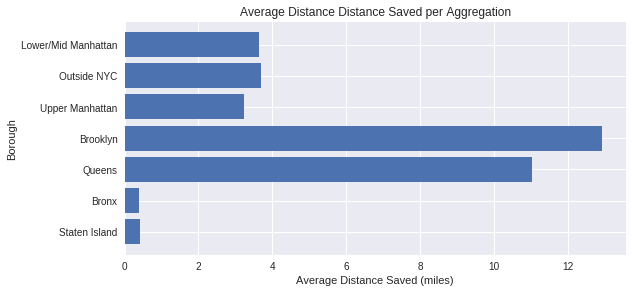

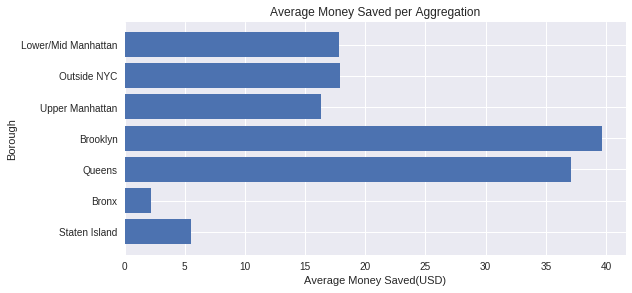

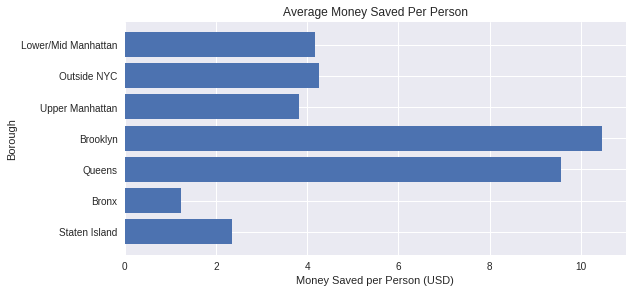

In [120]:
plt.style.use('seaborn')

grouped_borough_avg['total_distance'] = grouped_borough_sum['distance']

grouped_borough_avg = grouped_borough_avg.sort_values(by=['total_distance'])

plt.figure(figsize=(8, 4))
plt.barh(grouped_borough_avg['borough'], grouped_borough_avg['distance'])
plt.title('Average Distance Distance Saved per Aggregation')
plt.xlabel('Average Distance Saved (miles)')
plt.ylabel('Borough')
plt.savefig('Avg_distance_borough')
plt.show()

plt.figure(figsize=(8, 4))
plt.barh(grouped_borough_avg['borough'], grouped_borough_avg['money'])
plt.title('Average Money Saved per Aggregation')
plt.xlabel('Average Money Saved(USD)')
plt.ylabel('Borough')
plt.savefig('Avg_money_borough')
plt.show()

plt.figure(figsize=(8, 4))
plt.barh(grouped_borough_sum['borough'], grouped_borough_sum['money']/grouped_borough_sum['people'])
plt.title('Average Money Saved Per Person')
plt.xlabel('Money Saved per Person (USD)')
plt.ylabel('Borough')
plt.savefig('Avg_money_pp_borough')
plt.show()


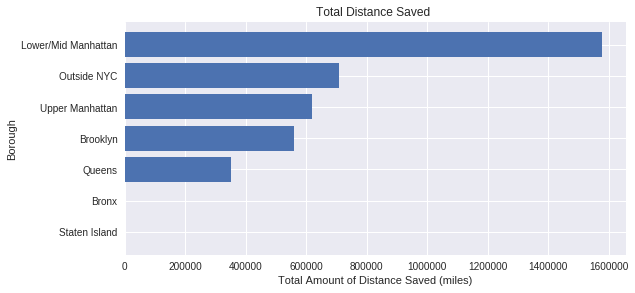

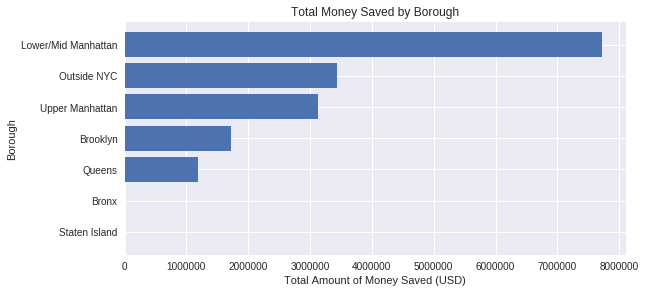

In [121]:
plt.style.use('seaborn')

borough_order = ['Lower/Mid Manhattan','Outside NYC','Upper Mnahattan', 'Brooklyn','Queens','Bronx','Staten Island']


grouped_borough_sum = grouped_borough_sum.sort_values(by=['distance'])

plt.figure(figsize=(8, 4))
plt.barh(grouped_borough_sum['borough'], grouped_borough_sum['distance'])
plt.title('Total Distance Saved ')
plt.xlabel('Total Amount of Distance Saved (miles)')
plt.ylabel('Borough')
plt.savefig('Total_distance_borough')
plt.show()

plt.figure(figsize=(8, 4))
plt.barh(grouped_borough_sum['borough'], grouped_borough_sum['money'])
plt.title('Total Money Saved by Borough')
plt.xlabel('Total Amount of Money Saved (USD)')
plt.ylabel('Borough')
plt.savefig('Total_money_borough')
plt.show()


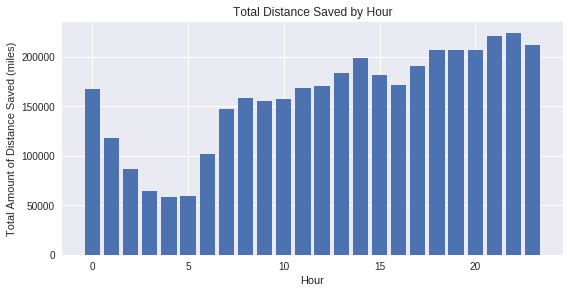

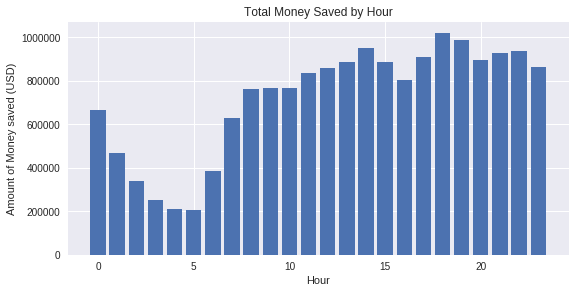

In [128]:
plt.style.use('seaborn')

plt.figure(figsize=(8, 4))
plt.bar(grouped_time_sum['Hour_of_day'], grouped_time_sum['distance'])
plt.title('Total Distance Saved by Hour')
plt.xlabel('Hour')
plt.ylabel('Total Amount of Distance Saved (miles)')
plt.savefig('Total_distance_time')
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(grouped_time_sum['Hour_of_day'], grouped_time_sum['money'])
plt.title('Total Money Saved by Hour')
plt.xlabel('Hour')
plt.ylabel('Amount of Money saved (USD)')
plt.savefig('Total_money_time')
plt.show()



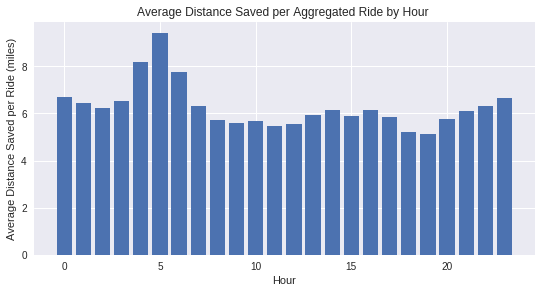

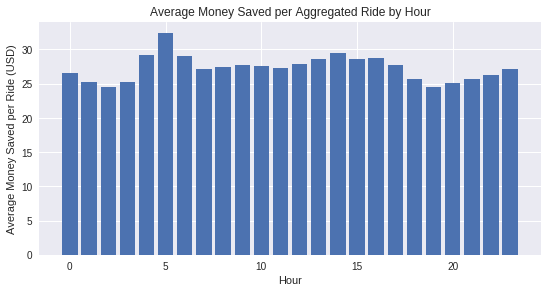

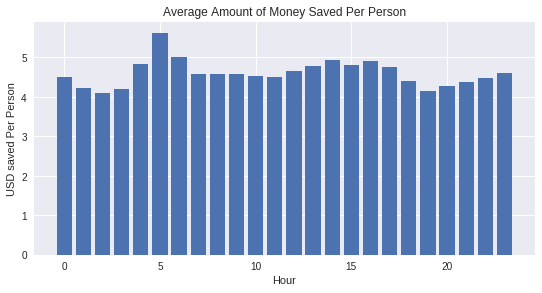

In [126]:
plt.style.use('seaborn')

plt.figure(figsize=(8, 4))
plt.bar(grouped_time_avg['Hour_of_day'], (grouped_time_avg['distance']))
plt.title('Average Distance Saved per Aggregated Ride by Hour ')
plt.xlabel('Hour')
plt.ylabel('Average Distance Saved per Ride (miles)')
plt.savefig('Avg_distance_time')
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(grouped_time_avg['Hour_of_day'], (grouped_time_avg['money']))
plt.title('Average Money Saved per Aggregated Ride by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Money Saved per Ride (USD)')
plt.savefig('Avg_money_time')
plt.show()


plt.figure(figsize=(8, 4))
plt.bar(grouped_time_sum['Hour_of_day'], (grouped_time_sum['money']/grouped_time_sum['people']))
plt.title('Average Amount of Money Saved Per Person by Hour')
plt.xlabel('Hour')
plt.ylabel('USD saved Per Person')
plt.savefig('Avg_money_pp_time')
plt.show()